In [7]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(os.path.abspath("."))

with open("keys/openai_api_key.txt") as f:
    os.environ["OPENAI_API_KEY"] = f.read().strip()

In [8]:
import numpy as np
import pandas as pd
prompts_path = "./experiments/runs/run_mastermind_gpt-4o_3_1726344837/prompts/prompts_0.csv"
prompts = pd.read_csv(prompts_path, sep = "|")
prompts.head()

,Unnamed: 0,context,query
0,0,Guess: 4 2 1 3\nResponse: 0 3\n\n,Guess: 4 2 1 3\nResponse: ? ?\n-----------\n\n...
1,1,Guess: 4 0 0 5\nResponse: 0 2\n\n,Guess: 4 0 0 5\nResponse: ? ?\n-----------\n\n...
2,2,Guess: 1 1 4 3\nResponse: 0 2\n\n,Guess: 1 1 4 3\nResponse: ? ?\n-----------\n\n...
3,3,Guess: 5 5 0 1\nResponse: 0 1\n\n,Guess: 5 5 0 1\nResponse: ? ?\n-----------\n\n...
4,4,Guess: 3 0 2 2\nResponse: 0 3\n\n,Guess: 3 0 2 2\nResponse: ? ?\n-----------\n\n...


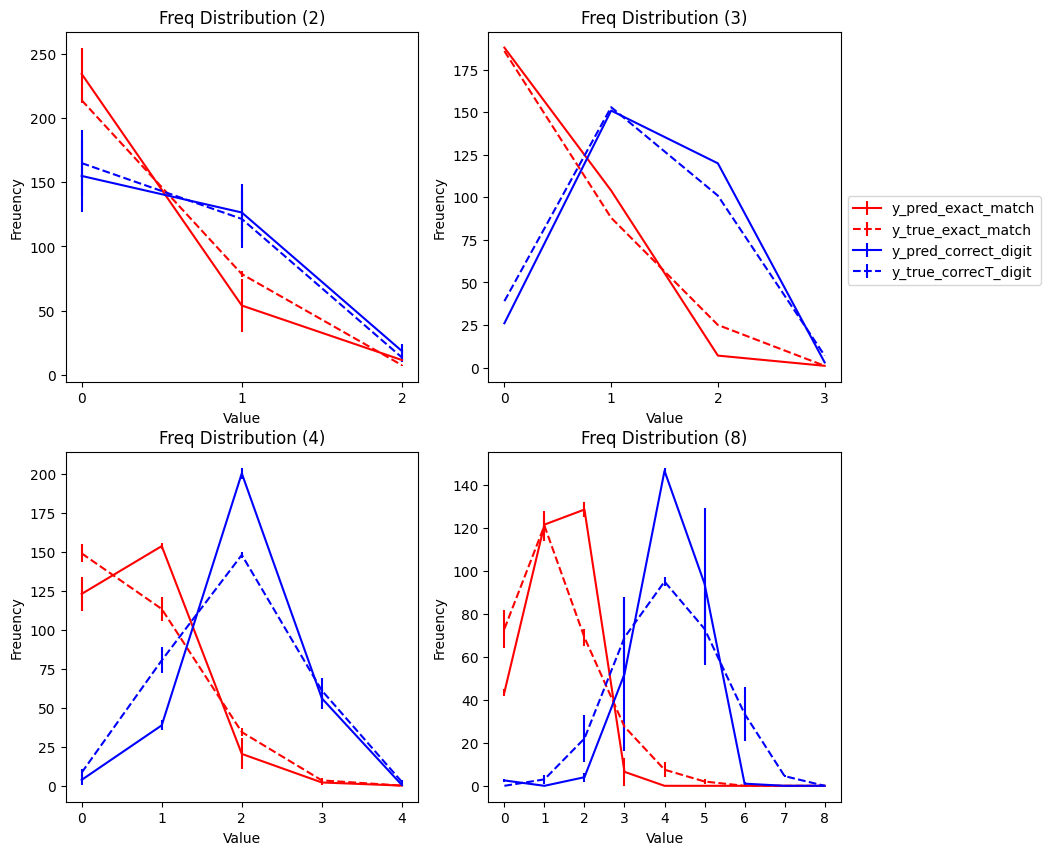

In [127]:
from src.viz import plot_y_histogram
from matplotlib import pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
result_paths = ["./experiments/runs/run_mastermind_gpt-4o_0_1726439611", "./experiments/runs/run_mastermind_gpt-4o_1_1726436871"]
plot_y_histogram(result_paths, 2, ax[0, 0])
result_paths = ["./experiments/runs/run_mastermind_gpt-4o_1_1726437523"]
plot_y_histogram(result_paths, 3, ax[0, 1])
result_paths = ["./experiments/runs/run_mastermind_gpt-4o_1_1726439196", "./experiments/runs/run_mastermind_gpt-4o_2_1726442336", "./experiments/runs/run_mastermind_gpt-4o_3_1726344837"]
plot_y_histogram(result_paths, 4, ax[1, 0])
result_paths = ["./experiments/runs/run_mastermind_gpt-4o_0_1726348490", "./experiments/runs/run_mastermind_gpt-4o_1_1726348962"]
plot_y_histogram(result_paths, 8, ax[1, 1])
plt.legend(loc='upper left', ncol=1, bbox_to_anchor=(1, 1.75))
plt.show()

In [9]:
from src.viz import plot_y_histogram
import matplotlib.pyplot as plt

def plot_y_histogram_2(result_paths, code_length, ax):
    y_preds_0 = []
    y_preds_1 = []

    y_trues_0 = []
    y_trues_1 = []
    unique_values = np.arange(0, code_length+1)
    for result_path in result_paths:
        y_pred = np.load(os.path.join(result_path, "results", "y_pred.npy"))
        y_true =np.load(os.path.join(result_path, "data", "y_true.npy"))
        counts = np.bincount(y_pred[..., 0].flatten(), minlength=code_length+1)
        y_preds_0.append(counts)
        counts = np.bincount(y_true[..., 0].flatten(), minlength=code_length+1)
        y_trues_0.append(counts)
        counts = np.bincount(y_pred[..., 1].flatten(), minlength=code_length+1)
        y_preds_1.append(counts)
        counts = np.bincount(y_true[..., 1].flatten(), minlength=code_length+1)
        y_trues_1.append(counts)

    y_preds_0 = np.stack(y_preds_0)
    y_trues_0 = np.stack(y_trues_0)
    y_preds_1 = np.stack(y_preds_1)
    y_trues_1 = np.stack(y_trues_1)

    ax.plot(unique_values, y_preds_0.sum(axis=0), label="y_pred_exact_match", c="red")
    ax.plot(unique_values, y_trues_0.sum(axis=0), label="y_true_exact_match", linestyle="--", c="red")
    ax.plot(unique_values, y_preds_1.sum(axis=0), label="y_pred_correct_digit", c="blue")
    ax.plot(unique_values, y_trues_1.sum(axis=0), label="y_pred_correct_digit",  linestyle="--", c="blue")
    ax.set_xticks(unique_values)
    ax.set_ylabel("Freuency")
    ax.set_xlabel("Value")
    ax.set_title(f"Freq Distribution ({code_length})")




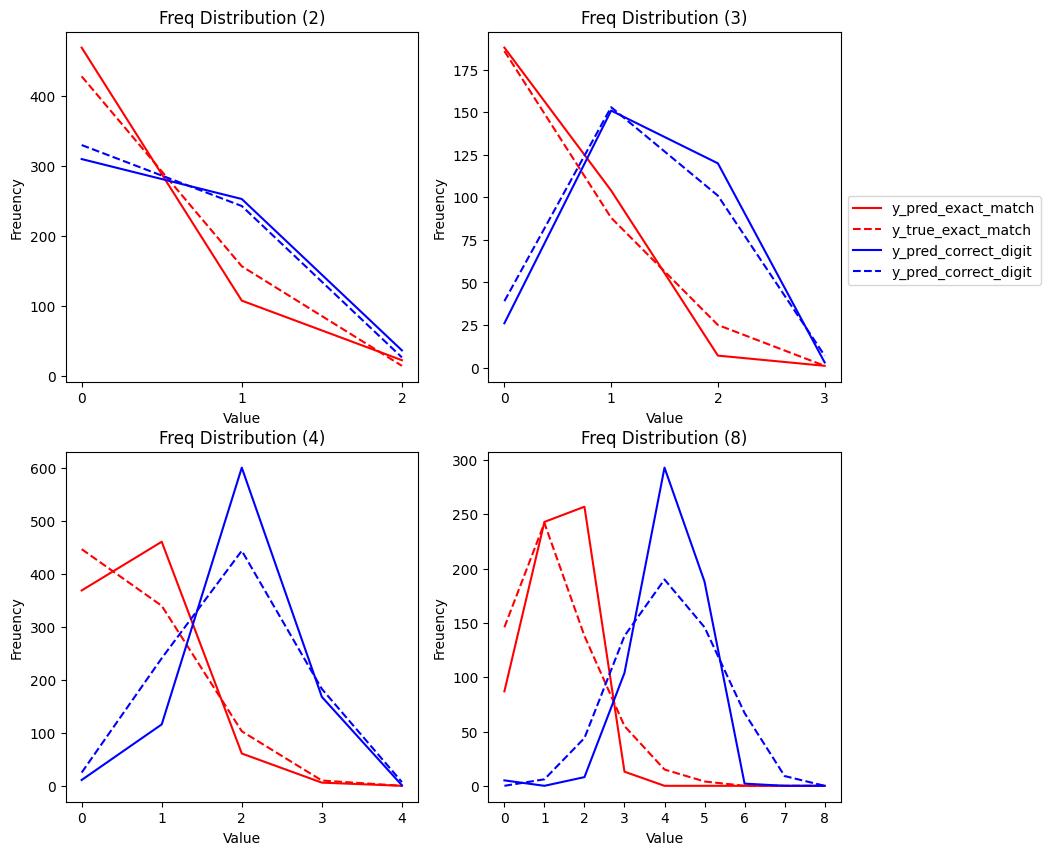

In [128]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
result_paths = ["./experiments/runs/run_mastermind_gpt-4o_0_1726439611", "./experiments/runs/run_mastermind_gpt-4o_1_1726436871"]
plot_y_histogram_2(result_paths, 2, ax[0, 0])
result_paths = ["./experiments/runs/run_mastermind_gpt-4o_1_1726437523"]
plot_y_histogram_2(result_paths, 3, ax[0, 1])
result_paths = ["./experiments/runs/run_mastermind_gpt-4o_1_1726439196", "./experiments/runs/run_mastermind_gpt-4o_2_1726442336", "./experiments/runs/run_mastermind_gpt-4o_3_1726344837"]
plot_y_histogram_2(result_paths, 4, ax[1, 0])
result_paths = ["./experiments/runs/run_mastermind_gpt-4o_0_1726348490", "./experiments/runs/run_mastermind_gpt-4o_1_1726348962"]
plot_y_histogram_2(result_paths, 8, ax[1, 1])
plt.legend(loc='upper left', ncol=1, bbox_to_anchor=(1, 1.75))
plt.show()

In [10]:
from src.utils import compute_marginal_dist, compute_marginal_baseline
from src.viz import log_results
import matplotlib.pyplot as plt
import json 

def update_metrics_with_marg_baseline(result_paths, code_length):
    for result_path in result_paths:
        y_true =np.load(os.path.join(result_path, "data", "y_true.npy"))
        with open(os.path.join(result_path, "results", "metrics.json"), "r") as f:
            metrics = json.load(f)
        loss_margin, probs_margin = compute_marginal_baseline(y_true, code_length=code_length)
        metrics["n_sample_loss_nexttoken_marg"] = loss_margin.mean(axis=0).tolist()
        metrics["probs_marg"] = probs_margin.mean(axis=0).tolist()
        with open(os.path.join(result_path, "results", "metrics.json"), "w") as f:
            json.dump(metrics, f)
    print("Done!")

def log_with_marginal_baseline(result_paths):
    for result_path in result_paths:
        with open(os.path.join(result_path, "results", "metrics.json"), "r") as f:
            metrics = json.load(f)
        with open(os.path.join(result_path, "metadata.json"), "r") as f:
            metadata = json.load(f)
        log_results(metrics=metrics, params=metadata)


def compute_marg_baseline_and_log(result_path, code_length):
    for result_path in result_paths:
        y_true = np.load(os.path.join(result_path, "data", "y_true.npy"))
        with open(os.path.join(result_path, "results", "metrics.json"), "r") as f:
            metrics = json.load(f)
        with open(os.path.join(result_path, "metadata.json"), "r") as f:
                metadata = json.load(f)
        loss_margin, probs_margin = compute_marginal_baseline(y_true, code_length=code_length)
        for i in range(len(y_true)):
            metrics["n_sample_loss_nexttoken_marg"] = loss_margin[i].tolist()
            metrics["probs_marg"] = probs_margin[i].tolist()
            metadata["task_no"] = i
            log_results(metrics=metrics, params=metadata)

In [14]:
result_paths = ["./experiments/runs/run_mastermind_gpt-4o_1_1726439196", "./experiments/runs/run_mastermind_gpt-4o_2_1726442336", "./experiments/runs/run_mastermind_gpt-4o_3_1726344837"]

for result_path in result_paths[:1]:
    y_true =np.load(os.path.join(result_path, "data", "y_true.npy"))
    exact_match = compute_marginal_dist(y_true[..., 0], code_length=4)
    correct_color = compute_marginal_dist(y_true[..., 1], code_length=4)
    for i in range(len(y_true)):
        samples = y_true.shape[1]
        fig, axes = plt.subplots(10, 20, figsize=(20, 10))

        for j in range(y_true.shape[1]):
            ax_0 = axes[j//10][j % 10]
            ax_1 = axes[j//10][j % 10 + 10]
            ax_0.bar(np.arange(5), exact_match[i][j], color = "red", label="exact_match", alpha=0.5)
            ax_1.bar(np.arange(5), correct_color[i][j], color = "blue", label="correct_color", alpha=0.5)
            ax_0.set_xticks(np.arange(5))
            ax_1.set_xticks(np.arange(5))
            ax_0.set_title(f"  {j}  ")
            ax_1.set_title(f"  {j}  ")

    plt.show()

In [ ]:
result_paths = ["./experiments/runs/run_mastermind_gpt-4o_1_1726439196", "./experiments/runs/run_mastermind_gpt-4o_2_1726442336", "./experiments/runs/run_mastermind_gpt-4o_3_1726344837"]
compute_marg_baseline_and_log(result_paths, 4)


In [ ]:

result_paths = ["./experiments/runs/run_mastermind_gpt-4o_0_1726439611", "./experiments/runs/run_mastermind_gpt-4o_1_1726436871"]
# update_metrics_with_marg_baseline(result_paths, 4)
# log_with_marginal_baseline(result_paths)
compute_marg_baseline_and_log(result_paths, 2)